In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import missingno as msno
import matplotlib
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

cd = "/Users/marimason/Documents/Data Science/Forecasting/Rossman Store Sales/Data"
os.chdir(cd)
current_directory = os.getcwd()
print(f"The current working directory is {current_directory}")

The current working directory is /Users/marimason/Documents/Data Science/Forecasting/Rossman Store Sales/Data


In [4]:
#Read in data from training file
store = pd.read_csv("store.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


/var/folders/lx/_8x9r4p95db9nb99vkl8fbkc0000gn/T/ipykernel_36363/1909314767.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


In [5]:
# Step 3: Data Exploration and Preprocessing
# Familiarize yourself with the data
print(train.head())  # Display the first few rows of the dataset
print(train.info())  # Get information about the dataset

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 n

In [6]:
#Merge training and store data since we will need to use store data to train the model
train_store = pd.merge(train, store, on='Store')

#Merge test and store data
test_store = pd.merge(test, store, on='Store')

In [7]:
print(train_store.head())  # Display the first few rows of the dataset
print(train_store.info())  # Get information about the dataset

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                   

<Axes: >

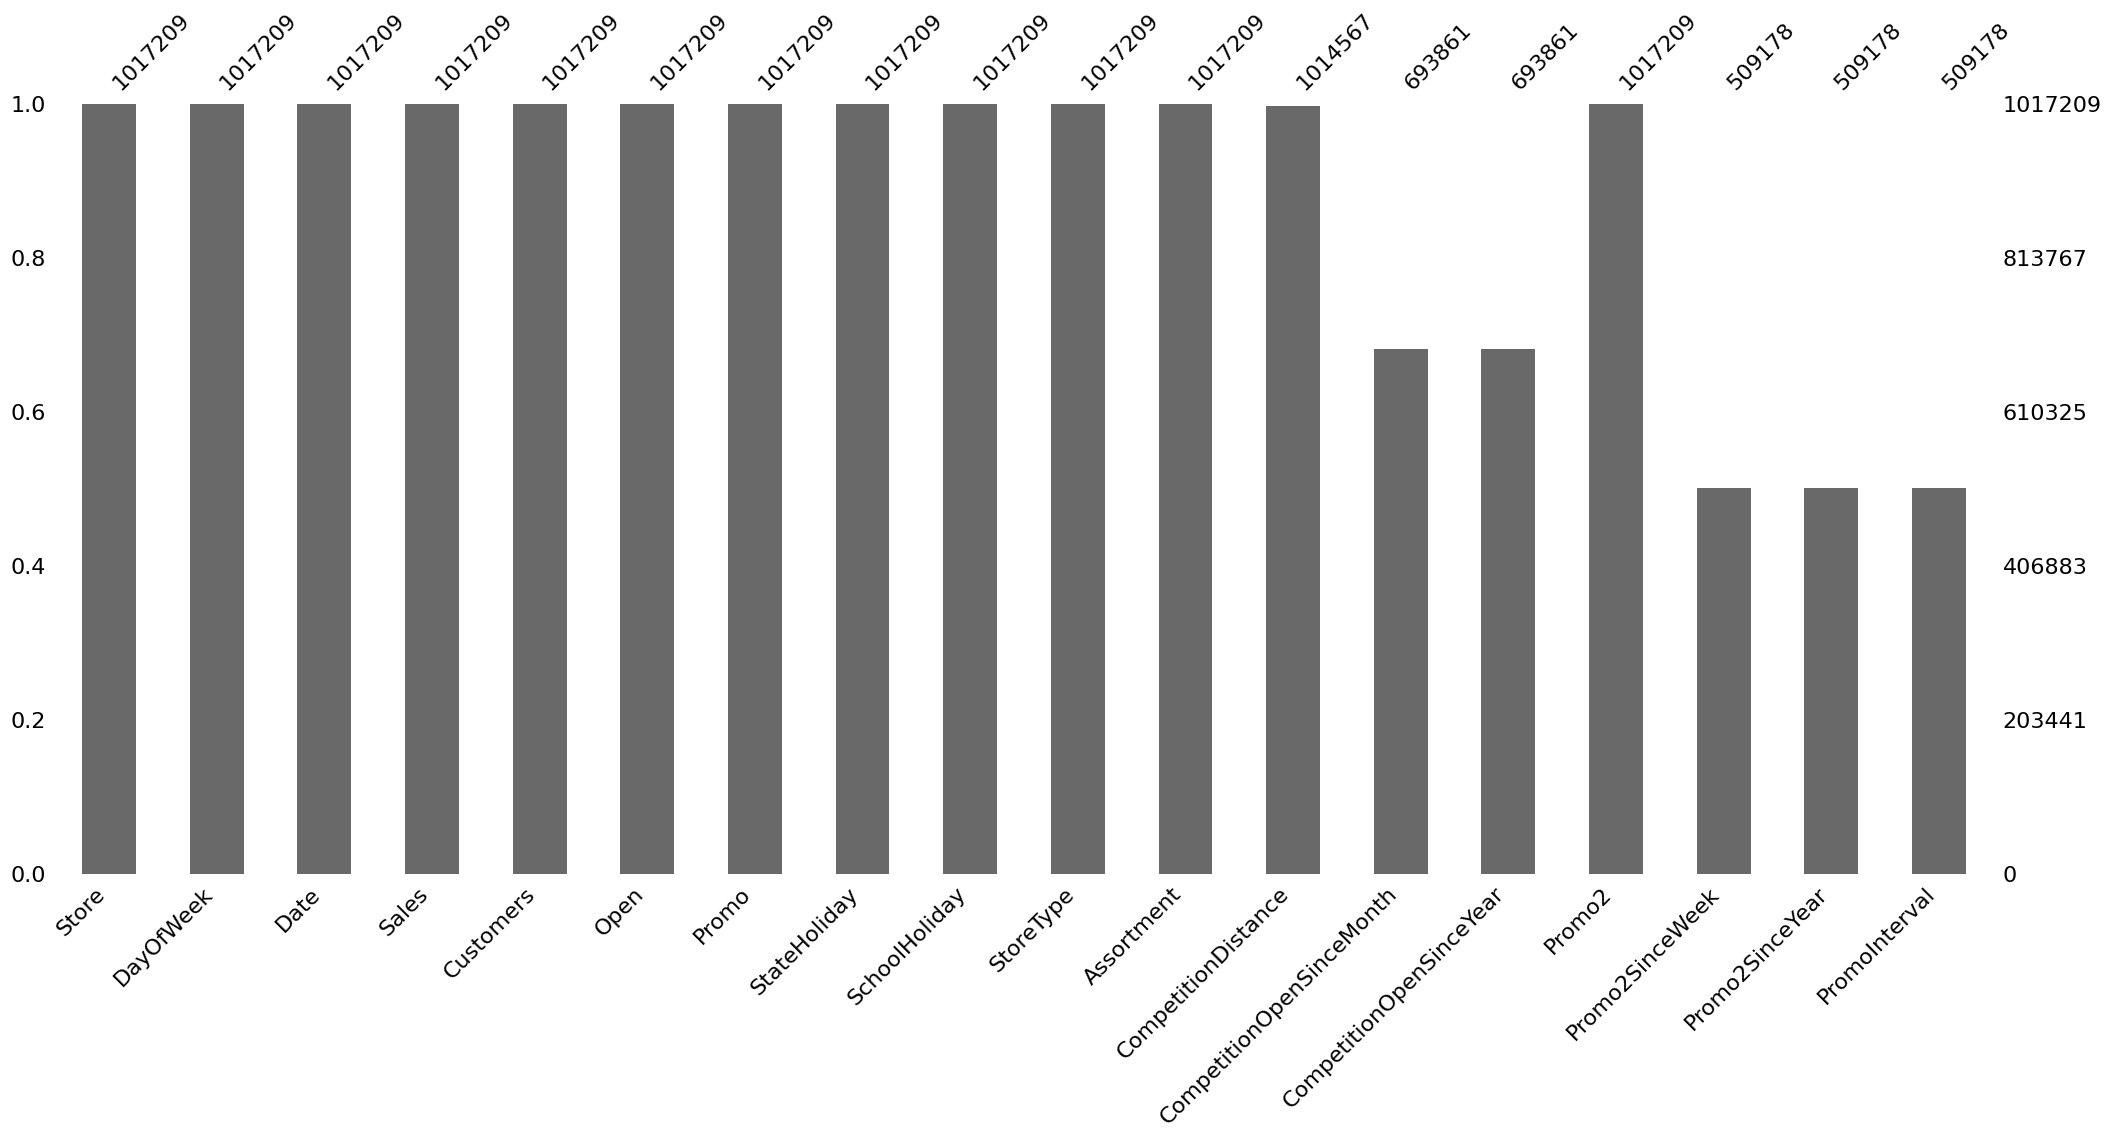

In [8]:
msno.bar(train_store)  # One of my first steps is to check for missing values and outliers

In [9]:
# This is just some asthetics settings for plots before we start EDA
pd.set_option('display.max_columns', None) #Enable to show max columns in code cells
sns.set_style('darkgrid') #set sns plot background
matplotlib.rcParams['font.size'] = 14 #set the deafult plot font size for this notebook
matplotlib.rcParams['figure.figsize'] = (10, 6) #set the deafult plot size for this notebook
matplotlib.rcParams['figure.facecolor'] = '#00000000' #set matplotlib plot background

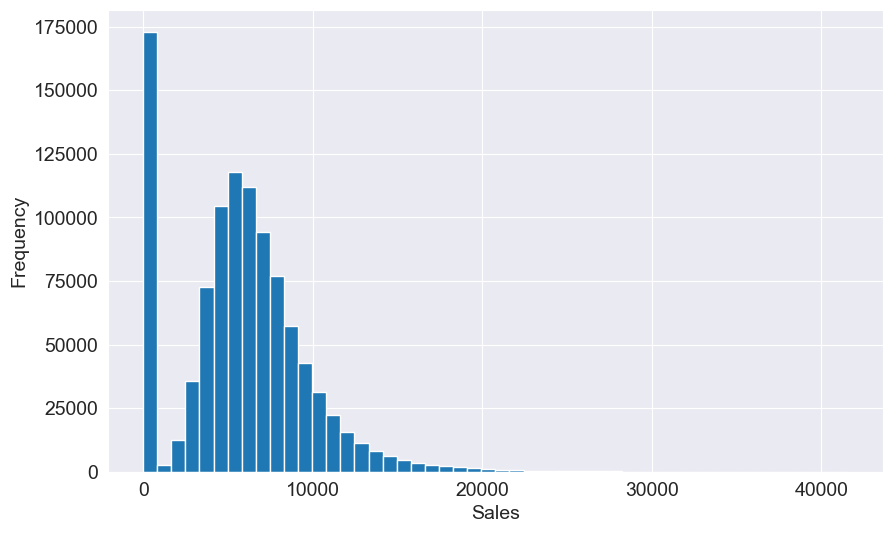

In [10]:
plt.hist(train_store['Sales'], bins=50)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()
#Here we plot the distribution of sales. We can see that there is a large number of 0 sales. This is likely due to the fact that the store is closed. But we will need to confirm this.

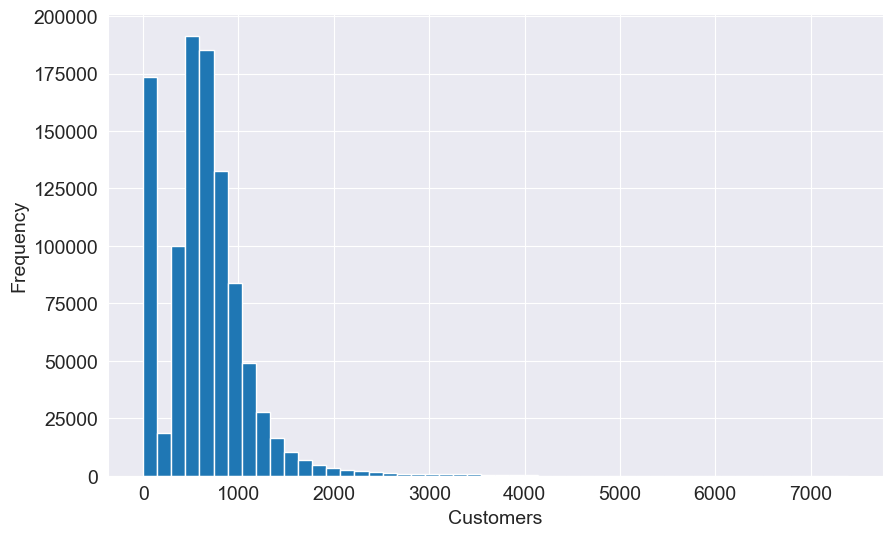

In [11]:
# Plot a histogram of the Customers column
plt.hist(train_store['Customers'], bins=50)
plt.xlabel('Customers')
plt.ylabel('Frequency')
plt.show()
#Here we can see again that there are a large number of 0 customers. This is likely due to the fact that the store is closed. But we will need to confirm this.

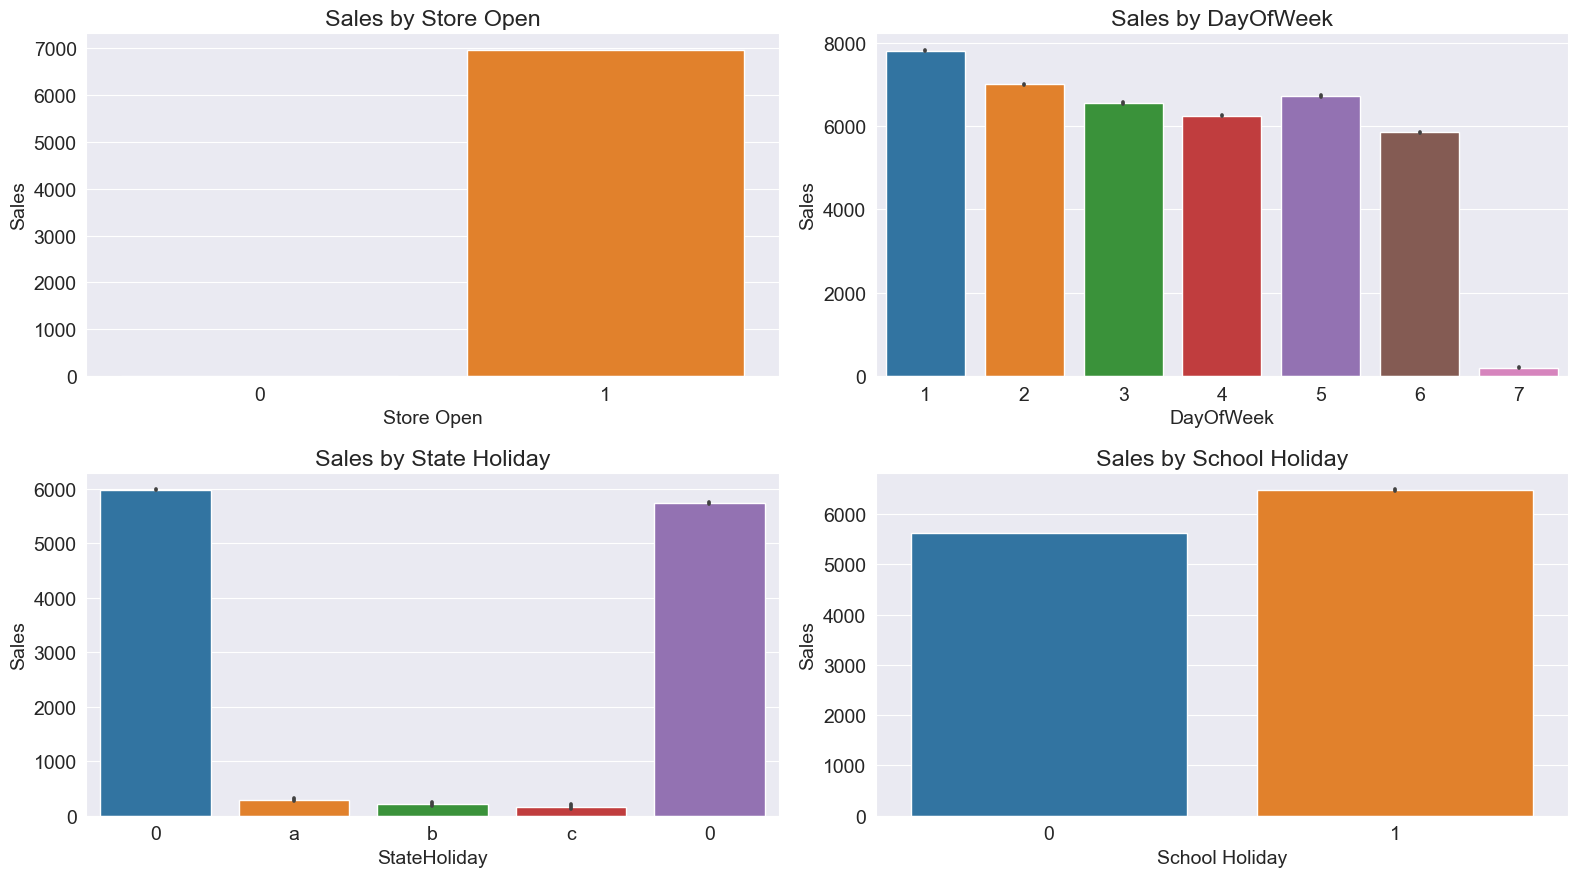

In [12]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))

# Bar plot of Sales by Store Open
sns.barplot(data=train_store, x="Open", y="Sales", ax=axes[0, 0])
axes[0, 0].set_title("Sales by Store Open")
axes[0, 0].set_xlabel("Store Open")
axes[0, 0].set_ylabel("Sales")

# Bar plot of Sales by DayOfWeek
sns.barplot(data=train_store, x="DayOfWeek", y="Sales", ax=axes[0, 1])
axes[0, 1].set_title("Sales by DayOfWeek")
axes[0, 1].set_xlabel("DayOfWeek")
axes[0, 1].set_ylabel("Sales")

# Bar plot of Sales by StateHoliday
sns.barplot(data=train_store, x="StateHoliday", y="Sales", ax=axes[1, 0])
axes[1, 0].set_title("Sales by State Holiday")
axes[1, 0].set_xlabel("StateHoliday")
axes[1, 0].set_ylabel("Sales")

# Bar plot of Sales by SchoolHoliday
sns.barplot(data=train_store, x="SchoolHoliday", y="Sales", ax=axes[1, 1])
axes[1, 1].set_title("Sales by School Holiday")
axes[1, 1].set_xlabel("School Holiday")
axes[1, 1].set_ylabel("Sales")

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [13]:
#The graphics above show that sales are only 0 when the store is closed or because of a state holiday. I won't remove them but I will make a note of this
#In a real world scenario I would spend more time deciding how to handle this so the model does not misinterpret the data

In [14]:
#This code shows the same information as above but in a different format that is easier to read

list_a = ['Open','StateHoliday','SchoolHoliday','DayOfWeek']

for i in list_a:
    a=0
    train_store
    a=train_store.groupby(by=i)["Sales"].sum()
    print(a);


Open
0             0
1    5873180623
Name: Sales, dtype: int64
StateHoliday
0     751505326
0    5113659442
a       5890305
b       1433744
c        691806
Name: Sales, dtype: int64
SchoolHoliday
0    4696260531
1    1176920092
Name: Sales, dtype: int64
DayOfWeek
1    1130203012
2    1020411930
3     954962863
4     911177709
5     980555941
6     846317735
7      29551433
Name: Sales, dtype: int64


In [15]:
#Preprocessing and Feature Engineering

#A helper function that takes a df and finds the Date column and extract the necessary information from it
def extract_date_info(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [16]:
extract_date_info(train_store)
extract_date_info(test_store)   
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,30,31
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,29,31
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,28,31
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,27,31


In [17]:
train_store = train_store[train_store.Open == 1].copy() #Filtering only the rows where the store is open.
train_store.groupby(by='Open')['Sales'].sum()

Open
1    5873180623
Name: Sales, dtype: int64

In [18]:
# Selecting only the required columns based on the EDA we did above and my domain knowledge
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance','Day', 'Month', 'Year', 'WeekOfYear',  'Promo2']
target_col = 'Sales'


inputs = train_store[input_cols].copy()
targets = train_store[target_col].copy()
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Day,Month,Year,WeekOfYear,Promo2
0,1,5,1,0,1,c,a,1270.0,31,7,2015,31,0
1,1,4,1,0,1,c,a,1270.0,30,7,2015,31,0
2,1,3,1,0,1,c,a,1270.0,29,7,2015,31,0
3,1,2,1,0,1,c,a,1270.0,28,7,2015,31,0
4,1,1,1,0,1,c,a,1270.0,27,7,2015,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,1,1,0,1,d,c,5350.0,7,1,2013,2,1
1017204,1115,6,0,0,1,d,c,5350.0,5,1,2013,1,1
1017205,1115,5,0,0,1,d,c,5350.0,4,1,2013,1,1
1017206,1115,4,0,0,1,d,c,5350.0,3,1,2013,1,1


In [19]:
# Similarly doing the same for the test dataset
test_inputs = test_store[input_cols].copy()
test_inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Day,Month,Year,WeekOfYear,Promo2
0,1,4,1,0,0,c,a,1270.0,17,9,2015,38,0
1,1,3,1,0,0,c,a,1270.0,16,9,2015,38,0
2,1,2,1,0,0,c,a,1270.0,15,9,2015,38,0
3,1,1,1,0,0,c,a,1270.0,14,9,2015,38,0
4,1,7,0,0,0,c,a,1270.0,13,9,2015,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1115,3,1,0,1,d,c,5350.0,5,8,2015,32,1
41084,1115,2,1,0,1,d,c,5350.0,4,8,2015,32,1
41085,1115,1,1,0,1,d,c,5350.0,3,8,2015,32,1
41086,1115,7,0,0,1,d,c,5350.0,2,8,2015,31,1


In [20]:
#Now let's categorize the columns with categorical data and numerical data
categorical_cols=['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']
numerical_cols=['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Day', 'Month', 'Year', 'WeekOfYear', 'Promo2']

In [21]:
#Impute missing data
inputs[numerical_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
Day                       0
Month                     0
Year                      0
WeekOfYear                0
Promo2                    0
dtype: int64

In [22]:
test_inputs[numerical_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
Day                     0
Month                   0
Year                    0
WeekOfYear              0
Promo2                  0
dtype: int64

In [23]:
#For this first pass I will impute with the max distance times 3 since the competition is nonexistent, but I will come back to this later to improve model performance
max_distance = inputs.CompetitionDistance.max()
print(max_distance)


inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True) 
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

75860.0


In [24]:
#Checking missing values after imputation
inputs[numerical_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo2                 0
dtype: int64

In [25]:
test_inputs[numerical_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo2                 0
dtype: int64

In [26]:
inputs[categorical_cols].isna().sum()

DayOfWeek       0
StateHoliday    0
StoreType       0
Assortment      0
dtype: int64

In [27]:
#Make categorical columns strings
inputs[categorical_cols] = inputs[categorical_cols].astype(str)

#Do the same for test data
test_inputs[categorical_cols] = test_inputs[categorical_cols].astype(str)

In [28]:
#Encoding categorical data
#Encoding refers to the process of converting each unique categorical value into a number.
#There are several ways to do this including One-Hot Encoding, Ordinal Encoding, and Label Encoding.
#The process used will depend entirely on your dataset and the model you are using. I will be using one hot encoding for this dataset.
inputs[categorical_cols].nunique()

#Handle unknown categories while encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])


In [29]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [30]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols]) #merging the encoded columns onto out inputs dataset
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])
inputs[encoded_cols]

,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1017204,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1017205,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1017206,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
#Standardization (Scale numerical data/standradize numerical data)
#It is important to scale the numerical data so that the model does not give more importance to one feature over the other.
#Some of the most common methods of scaling are mean normalization, min-max scaling, and standardization.
#For example, K-Means clustering uses distance measures to compare features and if they are on different scales the model will not perform how we want it to.
#The type of scaling will depend on your data and model.

#Here I will use StandardScaler from sklearn to scale the numerical data. However this is another parameter we can tune later to improve model performance
scaler = StandardScaler().fit(inputs[numerical_cols])

inputs[numerical_cols] = scaler.transform(inputs[numerical_cols])
test_inputs[numerical_cols] = scaler.transform(test_inputs[numerical_cols])

In [32]:
inputs[numerical_cols].describe().loc[['min','max']]

,Store,Promo,SchoolHoliday,CompetitionDistance,Day,Month,Year,WeekOfYear,Promo2
min,-1.732571,-0.897887,-0.489947,-0.539902,-1.708501,-1.457834,-1.070346,-1.573812,-0.997372
max,1.729942,1.113726,2.041038,13.540960,1.746347,1.851502,1.502796,1.970371,1.002635


In [33]:
#Now let's extract the numeric and encoded columns for training
X=inputs[encoded_cols + numerical_cols]
X_test = test_inputs[encoded_cols + numerical_cols]
X

,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Store,Promo,SchoolHoliday,CompetitionDistance,Day,Month,Year,WeekOfYear,Promo2
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.732571,1.113726,2.041038,-0.423877,1.746347,0.347258,1.502796,0.511002,-0.997372
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.732571,1.113726,2.041038,-0.423877,1.631185,0.347258,1.502796,0.511002,-0.997372
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.732571,1.113726,2.041038,-0.423877,1.516024,0.347258,1.502796,0.511002,-0.997372
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.732571,1.113726,2.041038,-0.423877,1.400862,0.347258,1.502796,0.511002,-0.997372
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.732571,1.113726,2.041038,-0.423877,1.285700,0.347258,1.502796,0.511002,-0.997372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.729942,1.113726,2.041038,-0.045169,-1.017531,-1.457834,-1.070346,-1.504318,1.002635
1017204,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.729942,-0.897887,2.041038,-0.045169,-1.247854,-1.457834,-1.070346,-1.573812,1.002635
1017205,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.729942,-0.897887,2.041038,-0.045169,-1.363016,-1.457834,-1.070346,-1.573812,1.002635
1017206,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.729942,-0.897887,2.041038,-0.045169,-1.478178,-1.457834,-1.070346,-1.573812,1.002635


In [34]:
#Gradient Boosting
#TO DO: INSERT INFO ABOUT GRADIENT BOOSTING HERE
#Some advantages of GBM are:
#Regularization: GBM has a regularization parameter to avoid overfitting.
#Scalability: GBM parallelizes the tree construction process. It also has a subsample parameter which can be used to train on a subset of data.
#Feature Importance: GBM calculates feature importance for us which can be used to select features, drop features, or even develop new features.
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=25, max_depth=5) #I will use XGBoost for this model

In [35]:
%%time

model.fit(X, targets)
#The main difference between XGB and RF is that RF uses bagging and XGB uses boosting aka RF builds trees independently while XGB builds trees sequentially to improve performance on the previous tree

CPU times: user 21.5 s, sys: 4.49 s, total: 26 s
Wall time: 2.39 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=25, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

In [36]:
#Now let's make predictions using model.predict
predictions = model.predict(X)
predictions
#This will generate an array of predictions for each row in our training dataset

array([7403.9805, 7051.925 , 6495.213 , ..., 6392.615 , 6114.2666,
       6287.7363], dtype=float32)

In [37]:
#We will evaluate our model using RMSE (Root Mean Squared Error)
#RMSE is used to measure the difference between the predicted values and the actual values
#RMSE penalizes the model for large errors more than MAE (Mean Absolute Error)

#RMSE Helper Function
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [38]:
#This shows the average error of our model in dollars
rmse(predictions, targets)

2180.812948416939

In [39]:
trees = model.get_booster().get_dump()

print(trees[0])

0:[Promo<0.107919127] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<-0.508807302] yes=15,no=16,missing=15
				15:[Promo2<0.00263151526] yes=31,no=32,missing=31
					31:leaf=2749.30151
					32:leaf=2015.70691
				16:[Store<1.72527933] yes=33,no=34,missing=33
					33:leaf=1814.53467
					34:leaf=3754.85571
			8:[WeekOfYear<1.65764904] yes=17,no=18,missing=17
				17:[CompetitionDistance<-0.518089294] yes=35,no=36,missing=35
					35:leaf=1826.56152
					36:leaf=1587.37695
				18:[DayOfWeek_1<0.5] yes=37,no=38,missing=37
					37:leaf=1911.60559
					38:leaf=2471.76562
		4:[CompetitionDistance<-0.427125275] yes=9,no=10,missing=9
			9:[CompetitionDistance<-0.445225298] yes=19,no=20,missing=19
				19:[CompetitionDistance<-0.460076571] yes=39,no=40,missing=39
					39:leaf=2880.33521
					40:leaf=1661.94458
				20:[DayOfWeek_7<0.5] yes=41,no=42,missing=41
					41:leaf=5117.58252
					42:leaf=7087.61865
			10:[

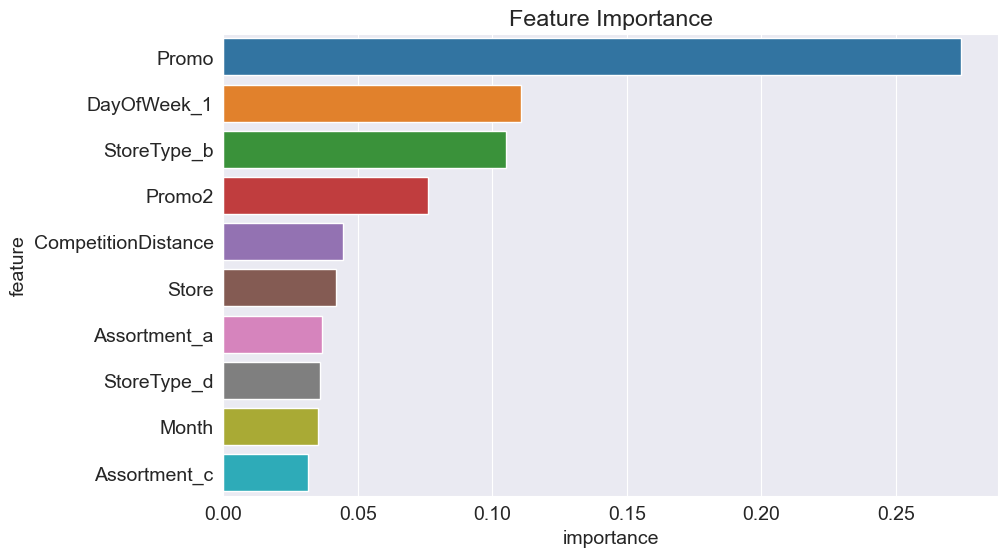

In [40]:
#Feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [41]:
#A general rule of thumb when working with chronological data is to split the data based on time so that the model is trained on past data and tested on future data.
#Will ignore for this project

#I will create a function to train, evaluate, and predict on our model automatically and help us find the optimal parameters for a final model

models = []

def train_eval_predict(X, targets, **params): 
    kfold = KFold(n_splits=12)
    train_rmses = []
    val_rmses = []
    temp_models=[]
    n_estimators=0
    max_depth=0
    for i, (train_indexs, val_indexs) in enumerate(kfold.split(X)):
        X_train, train_targets = X.iloc[train_indexs], targets.iloc[train_indexs]
        X_val, val_targets = X.iloc[val_indexs], targets.iloc[val_indexs]
        model = XGBRegressor(random_state=42, n_jobs=-1, **params)
        model.fit(X_train, train_targets)
        train_rmse = rmse(model.predict(X_train), train_targets)
        val_rmse = rmse(model.predict(X_val), val_targets)
        temp_models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        n_estimators=params['n_estimators']
        max_depth=params['max_depth']
        print(
            f'Iteration {i + 1}, Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}, Hyperparameters: n_estimators {n_estimators}, max_depth {max_depth}'
        )
        params['n_estimators'] += 1
        params['max_depth'] += 1
    return models.append(temp_models)

In [42]:
train_eval_predict(X,targets,n_estimators=5,max_depth=4)

Iteration 1, Train RMSE: 2915.60856795088, Validation RMSE: 2518.4418549801803, Hyperparameters: n_estimators 5, max_depth 4
Iteration 2, Train RMSE: 2723.0873520866703, Validation RMSE: 2127.2550308292484, Hyperparameters: n_estimators 6, max_depth 5
Iteration 3, Train RMSE: 2482.377897470989, Validation RMSE: 3236.7880624989093, Hyperparameters: n_estimators 7, max_depth 6
Iteration 4, Train RMSE: 2287.385212195319, Validation RMSE: 2397.0652696478155, Hyperparameters: n_estimators 8, max_depth 7
Iteration 5, Train RMSE: 2168.0453625805, Validation RMSE: 2708.1071118788777, Hyperparameters: n_estimators 9, max_depth 8
Iteration 6, Train RMSE: 1974.5646205667215, Validation RMSE: 3283.646832818011, Hyperparameters: n_estimators 10, max_depth 9
Iteration 7, Train RMSE: 1817.951538327108, Validation RMSE: 2703.6492198554092, Hyperparameters: n_estimators 11, max_depth 10
Iteration 8, Train RMSE: 1610.9755443038955, Validation RMSE: 2632.646275302819, Hyperparameters: n_estimators 12, ma

In [43]:
#If you look closely after 11 iterations the validation RMSE starts to increase while the training RMSE continues to decrease. This is a sign of overfitting.
#Overfitting is when the model learns the training data too well and does not generalize well to new data aka the model memorizes the training data and not necessarily the underlying patterns.

In [44]:
#Hyperparameter Tuning
#Regularization
#Regularization is a technique used to prevent overfitting by penalizing the model for large coefficients. The two main types of regularization are L1 and L2 regularization. L1 = Lasso Regression, L2 = Ridge Regression.
#L1 regularization adds a penalty equal to the absolute value of the magnitude of coefficients.
#L2 regularization adds a penalty equal to the square of the magnitude of coefficients.
#TO DO: ELI5 L1 and L2 regularization

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.3)

In [45]:
def test_params(**params): 
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}')
    
#This function will help us test different parameters and see how they affect our model
#The function first creates an instance of the model with 3 parameters: n_jobs, random_state, and **params
#N-Jobs is the number of parallel threads used to run XGBoost. This says all available threads will be used.
#random_state is the seed used by the random number generator and **params is the hyperparameters we want to test


In [46]:
test_params(n_estimators=10)

Train RMSE: 2366.885013771964, Validation RMSE: 2368.44961062202


In [47]:
test_params(n_estimators=50, learning_rate=0.9,max_depth=5)

Train RMSE: 1334.345382948412, Validation RMSE: 1343.8423117787597


In [48]:
#Putting it all together
#Now that we have a function to test our parameters, we can use it to find the optimal parameters for our model

#My final model

model = XGBRegressor(n_jobs=-1, random_state=42,n_estimators=900,   # Some parameters I think will be good 
                     learning_rate=0.15, max_depth=12, subsample=0.9, 
                     colsample_bytree=0.7)

In [49]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1,train_size=0.3)

model.fit(X_train, train_targets)
train_rmse = rmse(model.predict(X_train), train_targets)
val_rmse = rmse(model.predict(X_val), val_targets)
%%time
print(f"Train RMSE: {train_rmse} and Validation RMSE: {val_rmse}")

UsageError: Line magic function `%%time` not found.


In [52]:
pip install config

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
